In [ ]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# -----------------------------------------------------------------------------
# STEP 0: SETUP & LOAD DATA
# -----------------------------------------------------------------------------
data_path = Path("..") / "DATA" / "processed" / "master_df.parquet"

if not data_path.exists():
    raise FileNotFoundError("Master data not found. Please run the setup script.")

df_master = pd.read_parquet(data_path)
print(f"Loaded Data: {df_master.shape}")

Loaded Data: (9514, 41)


In [ ]:
# -----------------------------------------------------------------------------
# STEP 1: INPUT DATA (10Y Tenor Only)
# -----------------------------------------------------------------------------
# We focus on 10Y yields to define "Country Blocs" (e.g., Euro Bloc vs Dollar Bloc)
cols_10y = [c for c in df_master.columns if "bond_yields__" in c and "10Y" in c]

df_levels = df_master[cols_10y].copy()

df_levels = df_levels.ffill()

df_changes = df_levels.diff().dropna(how='all')

clean_names = {
    c: c.replace("bond_yields__", "").replace("GT", "").replace("10Y Govt", "") 
    for c in df_changes.columns
}
df_changes = df_changes.rename(columns=clean_names)

print(f"Tracking {df_changes.shape[1]} countries: {list(df_changes.columns)}")

Tracking 5 countries: ['USD', 'EUR', 'JPY', 'CNY', 'AUD']


In [ ]:
# -----------------------------------------------------------------------------
# STEP 2: RUN CLUSTERING
# -----------------------------------------------------------------------------
# Parameters
WINDOW = 252 
K = 3        

# Storage
cluster_history = []
dates = []

print(f"Starting Rolling Clustering (k={K}, window={WINDOW})...")

# Iterate
for i in range(WINDOW, len(df_changes)):
    current_date = df_changes.index[i]
    
    # 1. Get the Window
    window_data = df_changes.iloc[i-WINDOW : i]
    
    # a. Drop columns that have ANY missing values in this window
    #    (e.g., if China hasn't started trading yet, drop it)
    valid_data = window_data.dropna(axis=1, how='any')
    
    # b. Drop columns with ZERO variance (e.g., pegged currencies)
    valid_data = valid_data.loc[:, valid_data.std() > 1e-6]
    
    # Check if we have enough countries left to cluster
    # We need at least K countries to make K clusters
    if valid_data.shape[1] < K:
        full_labels = pd.Series(-1, index=df_changes.columns)
        cluster_history.append(full_labels.values)
        dates.append(current_date)
        continue

    # 2. Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(valid_data)
    
    # 3. Transpose
    X_transposed = X_scaled.T 
    
    # 4. Run K-Means
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_transposed)
    
    centers = kmeans.cluster_centers_
    order = np.argsort(centers.mean(axis=1))
    mapping = {old_lbl: new_lbl for new_lbl, old_lbl in enumerate(order)}
    consistent_labels = [mapping[l] for l in labels]
    
    # 5. Map back to Full List of Countries
    # Create a Series with the new labels, indexed by the country names
    daily_result = pd.Series(consistent_labels, index=valid_data.columns)
    
    # Reindex to the full list of columns (fills missing ones with NaN)
    full_result = daily_result.reindex(df_changes.columns)
    
    # Fill NaNs with -1 (meaning "No Data / Not Clustered")
    cluster_history.append(full_result.fillna(-1).values)
    dates.append(current_date)
    
    if i % 1000 == 0:
        print(f"   Processed {current_date.date()} ({valid_data.shape[1]} countries active)...")

# Convert to DataFrame
df_clusters = pd.DataFrame(cluster_history, index=dates, columns=df_changes.columns)
print("Clustering Complete!")

⏳ Starting Rolling Clustering (k=3, window=252)...
   Processed 1993-11-03 (3 countries active)...
   Processed 1997-09-03 (3 countries active)...
   Processed 2001-07-04 (4 countries active)...
   Processed 2005-04-29 (4 countries active)...
   Processed 2009-02-16 (5 countries active)...
   Processed 2012-11-14 (5 countries active)...
   Processed 2016-08-10 (5 countries active)...
   Processed 2020-05-08 (5 countries active)...
   Processed 2024-02-02 (5 countries active)...
✅ Clustering Complete!


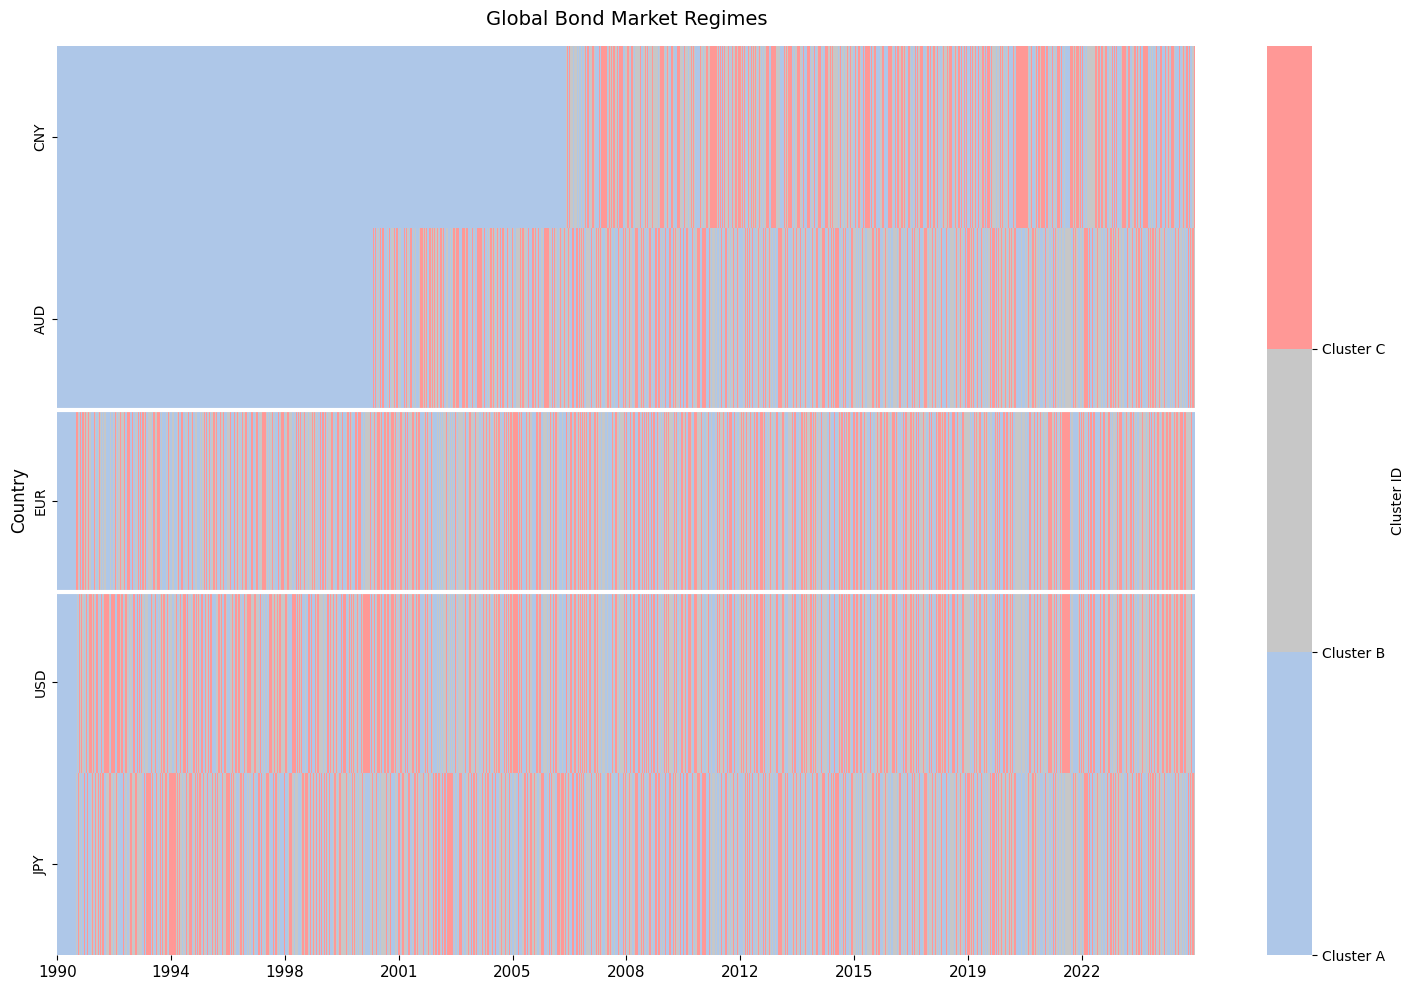


--- Transition Frequency Matrix ---


,0,1,2
USD,32.4%,33.0%,32.9%
EUR,33.7%,32.9%,31.8%
JPY,33.1%,34.4%,30.8%
CNY,17.1%,17.1%,21.1%
AUD,25.8%,25.2%,21.3%


In [14]:
# -----------------------------------------------------------------------------
# STEP 3: TRACK MEMBERSHIP
# -----------------------------------------------------------------------------

import matplotlib.colors as mcolors

# Cluster label per country per date
# Sort Countries by their "Primary Cluster"
primary_cluster = df_clusters.apply(lambda x: x.value_counts().idxmax())
sorted_countries = primary_cluster.sort_values().index
custom_colors = ['#AEC7E8', '#C7C7C7', '#FF9896']
cmap_custom = mcolors.ListedColormap(custom_colors[:K])

# Plot
plt.figure(figsize=(15, 10))

ax = sns.heatmap(
    df_clusters[sorted_countries].T,
    cmap=cmap_custom, 
    cbar_kws={'label': 'Cluster ID', 'ticks': range(K)},
    vmin=0, 
    vmax=K,
    linewidths=0.0,
    rasterized=True
)

# Add "Bloc Separators"
# Draws a white line between the groups of countries
for i, country in enumerate(sorted_countries):
    if i > 0 and primary_cluster[country] != primary_cluster[sorted_countries[i-1]]:
        plt.axhline(i, color='white', linewidth=3)

n_dates = len(df_clusters.index)
step = max(1, n_dates // 10) 
tick_indices = range(0, n_dates, step)
tick_labels = [df_clusters.index[i].strftime('%Y') for i in tick_indices]

ax.set_xticks(tick_indices)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=11)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(['Cluster A', 'Cluster B', 'Cluster C'])

plt.title("Global Bond Market Regimes", fontsize=14, pad=15)
plt.ylabel("Country", fontsize=12)
plt.xlabel("")
plt.tight_layout()
plt.show()

# Transition frequency matrix
# 1. Compute Matrix & Clean Data
membership_matrix = df_clusters.apply(pd.Series.value_counts, normalize=True).T

for bad_col in [-1, -1.0]:
    if bad_col in membership_matrix.columns:
        membership_matrix = membership_matrix.drop(columns=[bad_col])

membership_matrix = membership_matrix.fillna(0)

membership_matrix.columns = membership_matrix.columns.astype(int)

graph_colors = ['#AEC7E8', '#C7C7C7', '#FF9896']
def get_custom_cmap(hex_color):
    return mcolors.LinearSegmentedColormap.from_list("custom", ["#ffffff", hex_color])

styled_matrix = membership_matrix.style.format("{:.1%}")

for cluster_id in membership_matrix.columns:
    if cluster_id < len(graph_colors):
        specific_cmap = get_custom_cmap(graph_colors[cluster_id])
        styled_matrix = styled_matrix.background_gradient(
            cmap=specific_cmap, 
            subset=[cluster_id],
            vmin=0, vmax=1
        )

print("\n--- Transition Frequency Matrix ---")
display(styled_matrix)

In [15]:
# -----------------------------------------------------------------------------
# STEP 4: DELIVERABLES
# -----------------------------------------------------------------------------

# 1. Save the Time Series (Raw History)
ts_path = Path("..") / "DATA" / "processed" / "cluster_history_timeseries.csv"
df_clusters.to_csv(ts_path)

# 2. Save the Transition/Membership Table (The Matrix)
matrix_path = Path("..") / "DATA" / "processed" / "cluster_transition_matrix.csv"
membership_matrix.to_csv(matrix_path)

print(f"\nDeliverables Saved:")
print(f"   1. Time Series: {ts_path}")
print(f"   2. Transition Matrix: {matrix_path}")


Deliverables Saved:
   1. Time Series: ..\DATA\processed\cluster_history_timeseries.csv
   2. Transition Matrix: ..\DATA\processed\cluster_transition_matrix.csv
